## Supervised Machine Learning challenge on an imbalanced dataset

*Keywords:*

**Imbalanced dataset, XGBClassifier**

*Forewords:*

This script has been written during a Kaggle competition at the [Propulsion Academy](https://propulsion.academy/) during the Data Science Bootcamp 2020 (you can check the final project presentation of the student batch [here](https://drive.google.com/file/d/1WYcEVMIcYaRl6J4hg43KhBM5hvwHtYui/view?usp=sharing)). It was co-written with Chris Riccione.

*Dataset:*

The dataset contains two CSV files ‘features’ and ‘target’. Each row in the ‘features’ belongs to a ‘measurement’ and each column represents a ‘feature’. For each row in the ‘features’ there is a corresponding class label in ‘target’. Row-numbers are considered as keys. A dataset named ‘train’ was used to implement the models. The results obtained from the predictions of the Machine Learning models were submitted using a test dataset.

*Challenge:*

- Explore the data. Identify anything interest that is worth noting from the data?
- Define a set of possible classifiers and show which one performs best. Keep in mind the problem of overfitting.
- Using feature selection try to reduce the number of features. In the dataset there are over 120 features. Find the good ones for the classifier.

*Note on the data:*

The data exploration revealed that the dataset was **imbalanced**. The key in this challenge was to downsample the groups containing the most frequent label to prevent **overfitting*.

In [148]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import scikitplot as skplt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import resample
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

In [113]:
X_final_test = pd.read_csv("../data/features_test.csv")
X_final_test.head()

,Id,0,1,2,3,4,5,6,7,8,...,114,115,116,117,118,119,120,121,122,123
0,0,0.877693,0.469080,0.424460,0.998118,7.693946,-12.007347,1.096632,0.025091,0.469511,...,10.890676,0.682324,-1.064541,0.935477,0.660078,0.766286,1.668529,0.009139,-21.663660,0.183325
1,1,1.674469,-6.195271,3.509217,0.600414,6.893150,-8.410318,0.388152,1.012632,1.056344,...,-6.192967,0.293848,-4.318181,0.946655,0.086292,0.848392,0.955559,3.200346,-35.294749,2.220456
2,2,2.831142,15.086664,0.003076,1.289425,11.334080,3.473978,0.530828,18.930592,0.831549,...,12.382752,0.747345,-4.435824,0.269430,0.532336,0.427853,0.910760,0.529876,30.451371,1.434518
3,3,3.393066,-15.448951,0.017666,0.131593,2.660978,-9.344618,2.751585,0.140636,1.122829,...,9.471649,0.332602,6.202410,0.837661,0.026071,0.502790,-0.754858,0.002232,-53.005086,0.420866
4,4,2.719681,35.687756,0.004350,1.027668,0.542074,13.458556,0.002886,2.823077,0.568211,...,14.110742,0.403106,-0.346151,0.740334,0.303266,0.443808,0.650103,0.957909,-34.223193,6.363790


In [114]:
drop_list = ['Id']
X_final_test = X_final_test.drop(drop_list,axis = 1)
X_final_test.head()

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,0.877693,0.469080,0.424460,0.998118,7.693946,-12.007347,1.096632,0.025091,0.469511,0.822892,...,10.890676,0.682324,-1.064541,0.935477,0.660078,0.766286,1.668529,0.009139,-21.663660,0.183325
1,1.674469,-6.195271,3.509217,0.600414,6.893150,-8.410318,0.388152,1.012632,1.056344,0.139762,...,-6.192967,0.293848,-4.318181,0.946655,0.086292,0.848392,0.955559,3.200346,-35.294749,2.220456
2,2.831142,15.086664,0.003076,1.289425,11.334080,3.473978,0.530828,18.930592,0.831549,0.326581,...,12.382752,0.747345,-4.435824,0.269430,0.532336,0.427853,0.910760,0.529876,30.451371,1.434518
3,3.393066,-15.448951,0.017666,0.131593,2.660978,-9.344618,2.751585,0.140636,1.122829,0.180105,...,9.471649,0.332602,6.202410,0.837661,0.026071,0.502790,-0.754858,0.002232,-53.005086,0.420866
4,2.719681,35.687756,0.004350,1.027668,0.542074,13.458556,0.002886,2.823077,0.568211,-1.726259,...,14.110742,0.403106,-0.346151,0.740334,0.303266,0.443808,0.650103,0.957909,-34.223193,6.363790


In [4]:
X = pd.read_csv("../data/features_train.csv")
X.head()

,Id,0,1,2,3,4,5,6,7,8,...,114,115,116,117,118,119,120,121,122,123
0,0,2.837292,6.876604,148.413159,2.443542,0.190717,-0.879899,0.264097,16.627731,5.405047,...,-13.649896,0.300928,3.704019,0.578452,0.523759,0.116409,0.675754,0.016312,-31.767016,2.008720
1,1,0.518260,-8.371805,0.315937,0.343454,0.034839,-19.706822,3.333765,3.060854,0.113361,...,-5.548846,0.656999,2.376066,0.733390,0.467810,0.807791,-0.075898,0.009148,-4.784145,2.548898
2,2,1.839812,6.058536,0.496923,0.457393,0.072552,24.958362,0.262037,0.003101,1.381296,...,-6.460650,0.983519,-5.509158,0.272007,0.579664,0.848760,0.257566,1.770071,-82.086643,0.676950
3,3,0.199051,-8.538115,0.702203,4.089831,0.793226,-0.464069,0.408070,3.116768,0.763159,...,3.371071,0.986737,0.246915,0.217022,0.311443,0.683373,0.885297,0.189745,24.827932,0.996090
4,4,1.069817,-18.055101,0.082204,0.722185,0.028962,-0.673198,0.029112,74.009726,2.486090,...,-4.010314,0.013075,-3.205036,0.575523,0.279407,0.724725,-0.143733,3.295446,1.040429,1.612572


In [5]:
drop_list = ['Id']
X = X.drop(drop_list,axis = 1)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,2.837292,6.876604,148.413159,2.443542,0.190717,-0.879899,0.264097,16.627731,5.405047,0.772680,...,-13.649896,0.300928,3.704019,0.578452,0.523759,0.116409,0.675754,0.016312,-31.767016,2.008720
1,0.518260,-8.371805,0.315937,0.343454,0.034839,-19.706822,3.333765,3.060854,0.113361,-0.451800,...,-5.548846,0.656999,2.376066,0.733390,0.467810,0.807791,-0.075898,0.009148,-4.784145,2.548898
2,1.839812,6.058536,0.496923,0.457393,0.072552,24.958362,0.262037,0.003101,1.381296,-1.181609,...,-6.460650,0.983519,-5.509158,0.272007,0.579664,0.848760,0.257566,1.770071,-82.086643,0.676950
3,0.199051,-8.538115,0.702203,4.089831,0.793226,-0.464069,0.408070,3.116768,0.763159,1.289518,...,3.371071,0.986737,0.246915,0.217022,0.311443,0.683373,0.885297,0.189745,24.827932,0.996090
4,1.069817,-18.055101,0.082204,0.722185,0.028962,-0.673198,0.029112,74.009726,2.486090,-1.388754,...,-4.010314,0.013075,-3.205036,0.575523,0.279407,0.724725,-0.143733,3.295446,1.040429,1.612572


In [6]:
y = pd.read_csv("../data/target_train.csv") 
y.head()

,Id,Expected
0,0,2
1,1,1
2,2,2
3,3,2
4,4,1


In [7]:
y = y.drop(drop_list,axis = 1)
y.head()

,Expected
0,2
1,1
2,2
3,2
4,1


In [8]:
type(y)

pandas.core.frame.DataFrame

In [9]:
y.shape

(15000, 1)

### No missing values

In [10]:
X.isna().sum().sum()

0

### Correlations

In [11]:
ALL = pd.concat([X, y], axis=1)

In [12]:
ALL.head()

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,Expected
0,2.837292,6.876604,148.413159,2.443542,0.190717,-0.879899,0.264097,16.627731,5.405047,0.772680,...,0.300928,3.704019,0.578452,0.523759,0.116409,0.675754,0.016312,-31.767016,2.008720,2
1,0.518260,-8.371805,0.315937,0.343454,0.034839,-19.706822,3.333765,3.060854,0.113361,-0.451800,...,0.656999,2.376066,0.733390,0.467810,0.807791,-0.075898,0.009148,-4.784145,2.548898,1
2,1.839812,6.058536,0.496923,0.457393,0.072552,24.958362,0.262037,0.003101,1.381296,-1.181609,...,0.983519,-5.509158,0.272007,0.579664,0.848760,0.257566,1.770071,-82.086643,0.676950,2
3,0.199051,-8.538115,0.702203,4.089831,0.793226,-0.464069,0.408070,3.116768,0.763159,1.289518,...,0.986737,0.246915,0.217022,0.311443,0.683373,0.885297,0.189745,24.827932,0.996090,2
4,1.069817,-18.055101,0.082204,0.722185,0.028962,-0.673198,0.029112,74.009726,2.486090,-1.388754,...,0.013075,-3.205036,0.575523,0.279407,0.724725,-0.143733,3.295446,1.040429,1.612572,1


In [13]:
ALL.shape

(15000, 125)

In [14]:
ALL.isna().sum().sum()

0

In [15]:
corr_matrix = X.corr().abs()
corr_matrix

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,1.000000,0.002137,0.004453,0.007888,0.001153,0.013024,0.010721,0.010203,0.006501,0.000267,...,0.005277,0.007043,0.007655,0.006661,0.004711,0.000323,0.000062,0.000728,0.007597,0.006251
1,0.002137,1.000000,0.000984,0.001281,0.003765,0.016127,0.001624,0.004856,0.005852,0.001532,...,0.003438,0.001058,0.007803,0.005597,0.006321,0.016844,0.003601,0.013905,0.009891,0.002676
2,0.004453,0.000984,1.000000,0.000249,0.037271,0.011322,0.006424,0.046134,0.005390,0.002694,...,0.004451,0.006650,0.046378,0.000261,0.004978,0.014267,0.008480,0.009729,0.113989,0.010344
3,0.007888,0.001281,0.000249,1.000000,0.003165,0.017632,0.004374,0.003082,0.009106,0.013678,...,0.005999,0.004175,0.003194,0.005083,0.006806,0.009319,0.003210,0.002409,0.004893,0.005335
4,0.001153,0.003765,0.037271,0.003165,1.000000,0.014222,0.010496,0.046414,0.007516,0.008697,...,0.009389,0.005423,0.140180,0.000923,0.003974,0.002425,0.001969,0.001219,0.003042,0.005102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0.000323,0.016844,0.014267,0.009319,0.002425,0.000402,0.004005,0.006306,0.001159,0.004362,...,0.009507,0.006499,0.009823,0.005836,0.000745,1.000000,0.014941,0.002229,0.001144,0.007132
120,0.000062,0.003601,0.008480,0.003210,0.001969,0.002401,0.009761,0.001567,0.012903,0.001498,...,0.001695,0.004865,0.001410,0.004576,0.006400,0.014941,1.000000,0.013357,0.008083,0.000534
121,0.000728,0.013905,0.009729,0.002409,0.001219,0.006799,0.003610,0.005040,0.001018,0.009937,...,0.005219,0.009221,0.009533,0.005712,0.012163,0.002229,0.013357,1.000000,0.011174,0.009024
122,0.007597,0.009891,0.113989,0.004893,0.003042,0.004914,0.001451,0.023107,0.006532,0.008595,...,0.013567,0.018614,0.016113,0.009281,0.002855,0.001144,0.008083,0.011174,1.000000,0.003780


In [16]:
def find_features_to_drop(df: pd.DataFrame, correlation_level = 0.5):
    '''
    This function analyzes the dataframe for correlation between the columns 
    and outputs a list of column names of redundant columns since they are 
    correlated to a kept column by a correlation_index of more than 
    correlation_level.
    '''
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_level)]
    
    return to_drop

In [17]:
to_drop = find_features_to_drop(X, correlation_level=0.7)
X_reduced = X.drop(columns = to_drop)
#X_test_reduced  = X_test.drop(columns = to_drop)

In [18]:
X.shape

(15000, 124)

In [19]:
X_reduced.shape

(15000, 124)

No highly correlated features

In [20]:
to_drop = find_features_to_drop(ALL, correlation_level=0.3)
ALL_reduced = ALL.drop(columns = to_drop)
#X_test_reduced  = X_test.drop(columns = to_drop)

In [21]:
ALL.shape

(15000, 125)

### Downsampling

In [22]:
y = y.iloc[:,0]
type(y)

pandas.core.series.Series

In [23]:
y.value_counts(dropna=False)

1    8930
2    4501
0    1569
Name: Expected, dtype: int64

In [24]:
# Separate majority and minority classes
ALL_0 = ALL[ALL.Expected==0]
ALL_1 = ALL[ALL.Expected==1]
ALL_2 = ALL[ALL.Expected==2]
 
# Downsample majority class
ALL_1_downsampled = resample(ALL_1, 
                            replace=False,    # sample without replacement
                            n_samples=1569,     # to match minority class
                            random_state=123) # reproducible results

ALL_2_downsampled = resample(ALL_2, 
                            replace=False,    # sample without replacement
                            n_samples=1569,     # to match minority class
                            random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
ALL_downsampled = pd.concat([ALL_0, ALL_1_downsampled, ALL_2_downsampled])
 
# Display new class counts
ALL_downsampled.Expected.value_counts()

2    1569
1    1569
0    1569
Name: Expected, dtype: int64

In [25]:
ALL_downsampled.shape

(4707, 125)

In [26]:
ALL_downsampled.head()

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,Expected
10,0.365760,-15.200390,1.512526,1.907119,0.001283,7.229897,0.079480,2.914305,3.483309,0.148979,...,0.855979,1.106744,0.080609,0.408810,0.694052,0.751566,0.647357,-10.855225,0.727539,0
20,1.572794,0.412675,0.339589,2.723821,4.092196,7.743282,0.028040,0.430024,1.385044,-0.637686,...,0.856297,0.117453,0.536804,0.382630,0.652895,-1.254065,1.055122,-13.661478,0.625038,0
25,4.020966,5.184702,103.925144,1.381761,0.118405,-13.936705,0.074970,32.712380,1.059209,1.447388,...,0.950488,-6.735874,0.932197,0.640017,0.734073,-0.121809,0.303347,53.803799,2.144376,0
36,0.845618,-20.410371,4.186201,0.642441,0.157744,-10.261180,0.789931,12.938663,0.475192,2.643552,...,0.087496,-1.547513,0.692611,0.522075,0.217608,0.097705,0.026275,0.572077,0.406709,0
52,3.030915,-4.508441,0.118508,1.314744,0.012811,-2.756352,0.278854,0.000050,0.594083,0.854661,...,0.419045,0.255564,0.057255,0.388916,0.748798,-0.681552,0.024141,-32.950348,0.149282,0


For later - Upsample data set

In [27]:
ALL_downsampled = ALL_downsampled.reset_index(drop=True)
ALL_downsampled.head()

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,Expected
0,0.365760,-15.200390,1.512526,1.907119,0.001283,7.229897,0.079480,2.914305,3.483309,0.148979,...,0.855979,1.106744,0.080609,0.408810,0.694052,0.751566,0.647357,-10.855225,0.727539,0
1,1.572794,0.412675,0.339589,2.723821,4.092196,7.743282,0.028040,0.430024,1.385044,-0.637686,...,0.856297,0.117453,0.536804,0.382630,0.652895,-1.254065,1.055122,-13.661478,0.625038,0
2,4.020966,5.184702,103.925144,1.381761,0.118405,-13.936705,0.074970,32.712380,1.059209,1.447388,...,0.950488,-6.735874,0.932197,0.640017,0.734073,-0.121809,0.303347,53.803799,2.144376,0
3,0.845618,-20.410371,4.186201,0.642441,0.157744,-10.261180,0.789931,12.938663,0.475192,2.643552,...,0.087496,-1.547513,0.692611,0.522075,0.217608,0.097705,0.026275,0.572077,0.406709,0
4,3.030915,-4.508441,0.118508,1.314744,0.012811,-2.756352,0.278854,0.000050,0.594083,0.854661,...,0.419045,0.255564,0.057255,0.388916,0.748798,-0.681552,0.024141,-32.950348,0.149282,0


In [57]:
ALL2 = pd.get_dummies(ALL_downsampled, columns=['Expected'])
to_drop = find_features_to_drop(ALL2, correlation_level>0.7)
to_drop

#ALL_reduced = ALL_downsampled.drop(columns = to_drop)
#X_test_reduced  = X_test.drop(columns = to_drop)

NameError: name 'correlation_level' is not defined

Again no Correlations

In [29]:
X_downsampled = ALL_downsampled.iloc[:, 0:124]
y_downsampled = ALL_downsampled.iloc[:, 124]

In [30]:
X_downsampled.head()

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,0.365760,-15.200390,1.512526,1.907119,0.001283,7.229897,0.079480,2.914305,3.483309,0.148979,...,4.406687,0.855979,1.106744,0.080609,0.408810,0.694052,0.751566,0.647357,-10.855225,0.727539
1,1.572794,0.412675,0.339589,2.723821,4.092196,7.743282,0.028040,0.430024,1.385044,-0.637686,...,13.389379,0.856297,0.117453,0.536804,0.382630,0.652895,-1.254065,1.055122,-13.661478,0.625038
2,4.020966,5.184702,103.925144,1.381761,0.118405,-13.936705,0.074970,32.712380,1.059209,1.447388,...,-17.815692,0.950488,-6.735874,0.932197,0.640017,0.734073,-0.121809,0.303347,53.803799,2.144376
3,0.845618,-20.410371,4.186201,0.642441,0.157744,-10.261180,0.789931,12.938663,0.475192,2.643552,...,-4.862617,0.087496,-1.547513,0.692611,0.522075,0.217608,0.097705,0.026275,0.572077,0.406709
4,3.030915,-4.508441,0.118508,1.314744,0.012811,-2.756352,0.278854,0.000050,0.594083,0.854661,...,2.242144,0.419045,0.255564,0.057255,0.388916,0.748798,-0.681552,0.024141,-32.950348,0.149282


In [31]:
y_downsampled.head()

0    0
1    0
2    0
3    0
4    0
Name: Expected, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled, test_size=0.3, random_state=0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 3294 samples.
Testing set has 1413 samples.


### Preliminary Feature selection 

              precision    recall  f1-score   support

           0       0.60      0.49      0.54       476
           1       0.59      0.63      0.61       476
           2       0.56      0.63      0.59       461

    accuracy                           0.58      1413
   macro avg       0.58      0.58      0.58      1413
weighted avg       0.58      0.58      0.58      1413

[[235 113 128]
 [ 78 299  99]
 [ 78  93 290]]
Accuracy: 58.32%


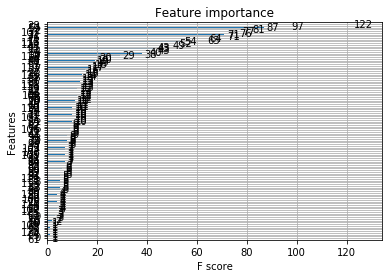

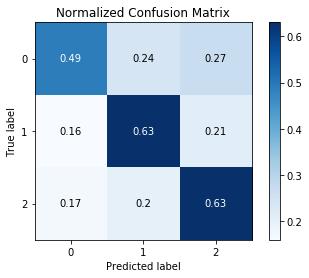

In [33]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

predictions = xgb.predict(X_test)

plot_importance(xgb)

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [116]:
importances = pd.DataFrame(
    {"feature": X_train.columns, "importance": np.round(xgb.feature_importances_, 3)}
)
importances = importances.sort_values("importance", ascending=False).set_index(
    "feature"
)
importances

AttributeError: module 'xgboost' has no attribute 'feature_importances_'

In [115]:
to_keep = importances.iloc[0:50, 0:1]

X_train = X_train[list(to_keep.index.values)]
X_test = X_test[list(to_keep.index.values)]
X_final_test = X_final_test[list(to_keep.index.values)]
X_train



AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [117]:
X_test.columns

Index(['28', '54', '2', '61', '45', '57', '76', '116', '107', '71', '11', '13',
       '122', '72', '19', '21', '67', '70', '113', '48', '97', '87', '4', '36',
       '24', '30', '31', '56', '34', '119', '73', '90', '64', '109', '75',
       '46', '12', '59', '65', '101', '85', '29', '38', '58', '110', '7',
       '114', '91', '118', '89'],
      dtype='object')

### Random Search - XGB Classifier

In [95]:
pipe_rf = Pipeline([("scl", StandardScaler()), ('select_K_features', SelectKBest(f_classif)), ('clf', XGBClassifier())])

parameters_rf = {'select_K_features__k': range(1, 50), 
                 'clf__n_estimators' : np.linspace(50, 1200).astype(int), 
                 'clf__learning_rate' : np.around(np.linspace(0.01, 0.08, 15), decimals=3),
                 'clf__max_depth' : range(2, 10),
                 'clf__min_child_weight' : [0, 1],
                }

randsearch_rf = RandomizedSearchCV(pipe_rf, parameters_rf, cv = 5, scoring = 'f1_macro', n_jobs=-1, n_iter=10, verbose = 1)

randsearch_rf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scl',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('select_K_features',
                                              SelectKBest(k=10,
                                                          score_func=<function f_classif at 0x000001FED31A2DC8>)),
                                             ('clf',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
             

In [96]:
randsearch_rf.best_estimator_

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('select_K_features',
                 SelectKBest(k=30,
                             score_func=<function f_classif at 0x000001FED31A2DC8>)),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.075,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=0, missing=None,
                               n_estimators=801, n_jobs=1, nthread=None,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         

In [97]:
randsearch_rf.best_params_

{'select_K_features__k': 30,
 'clf__n_estimators': 801,
 'clf__min_child_weight': 0,
 'clf__max_depth': 7,
 'clf__learning_rate': 0.075}

In [98]:
importances = randsearch_rf.best_estimator_.named_steps['clf'].feature_importances_
print(importances)

[0.03088142 0.03733568 0.03850251 0.03571284 0.04224735 0.04072013
 0.04233023 0.04256798 0.04000778 0.03855875 0.04285379 0.04162822
 0.04232835 0.04167456 0.02732153 0.03610519 0.02584297 0.03498263
 0.03950382 0.02914746 0.02411679 0.02429107 0.02470015 0.0247148
 0.02713049 0.02285224 0.02392249 0.0281192  0.02547348 0.0244261 ]


In [99]:
randsearch_rf.best_estimator_.named_steps['select_K_features'].get_support()

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True, False,  True,  True, False, False,  True,  True,
        True, False, False,  True, False, False, False, False,  True,
        True,  True, False, False, False, False, False,  True, False,
        True,  True,  True, False, False])

In [100]:
selected_features = X_train.columns[randsearch_rf.best_estimator_.named_steps['select_K_features'].get_support()]
selected_features

Index(['28', '54', '2', '45', '57', '76', '116', '107', '71', '11', '13',
       '122', '72', '21', '67', '113', '48', '87', '4', '30', '31', '56', '73',
       '46', '12', '59', '58', '7', '114', '91'],
      dtype='object')

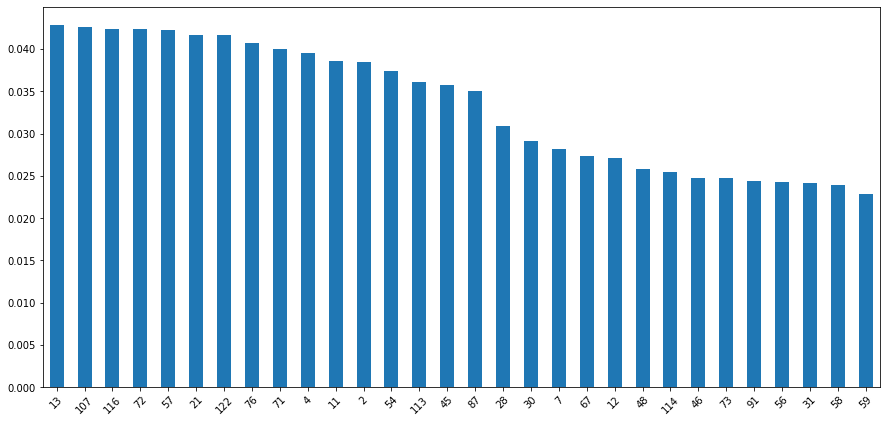

In [102]:
feat_importances = pd.Series(importances, index=selected_features)
feat_importances.nlargest(30).plot(kind='bar', rot=45, figsize=(15,7));

In [106]:
predictions = randsearch_rf.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.67      0.60      0.63       476
           1       0.64      0.67      0.66       476
           2       0.63      0.67      0.65       461

    accuracy                           0.64      1413
   macro avg       0.65      0.64      0.64      1413
weighted avg       0.65      0.64      0.64      1413



In [110]:
X_final_test[selected_features]

,28,54,2,45,57,76,116,107,71,11,...,31,56,73,46,12,59,58,7,114,91
0,-1.651179,2.625624,0.424460,-1.429084,-3.011217,0.481778,-1.064541,0.040796,-1.435994,4.720857,...,0.535096,1.018317,4.856697,0.419302,1.124391,1.197472,0.714613,0.025091,10.890676,4.292516
1,2.220950,0.682162,3.509217,-0.341400,4.235636,2.927998,-4.318181,1.413569,-0.654818,9.894630,...,0.043129,1.112535,-16.992830,0.984911,-0.803168,0.492624,0.740651,1.012632,-6.192967,0.555747
2,-3.148091,-3.765401,0.003076,-2.910801,-6.264697,3.188125,-4.435824,24.719778,-5.955837,1.335711,...,0.319250,0.733980,-3.677816,0.216159,-0.384634,0.772026,0.240055,18.930592,12.382752,0.806236
3,-0.896586,-1.885291,0.017666,-3.925404,1.736836,-2.524108,6.202410,5.060159,3.418909,228.594140,...,-0.631580,0.442199,-2.766680,0.526922,0.018679,0.981190,2.233170,0.140636,9.471649,2.189169
4,5.257986,0.383375,0.004350,-1.804224,4.053626,-3.186689,-0.346151,0.046974,-2.500249,255.045817,...,-2.151093,0.828549,-3.099961,0.069791,0.767855,6.615081,1.201226,2.823077,14.110742,0.768599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.293177,-4.176583,0.010656,0.292386,-1.032756,-2.353286,-3.576705,2.326178,-7.953103,12.111438,...,2.074596,0.166348,-10.636979,0.507650,0.040807,1.151321,0.957530,3.522302,-23.222719,0.437660
19996,4.301669,-1.065257,0.002032,3.880091,2.452386,1.421497,-2.985609,0.209069,1.355000,1484.131591,...,-0.456076,3.024247,8.506704,0.976415,0.450716,0.831923,0.087600,7.470686,3.828716,1.139302
19997,-2.761837,0.200529,0.122727,-5.757901,3.392497,-2.241271,-3.294669,1.811649,-3.320449,36.596743,...,-0.290029,0.850049,-7.448871,0.856316,0.659066,3.470450,0.650097,24.345709,3.334561,1.449319
19998,-1.286394,3.916386,0.024491,-0.047631,2.941546,-0.023766,0.300117,5.069696,-0.287965,3.157753,...,-1.338143,0.315307,-18.470808,0.078406,2.134047,1.330677,1.258143,33.376886,2.881706,0.720234


In [121]:
predictions = randsearch_rf.best_estimator_.predict(X_final_test[X_test.columns])
pred_copy = predictions

In [120]:
type(predictions)

numpy.ndarray

In [124]:
df = pd.DataFrame(predictions, columns = ["Predicted"])
df

,Predicted
0,2
1,2
2,1
3,1
4,2
...,...
19995,1
19996,0
19997,1
19998,2


In [125]:
df.to_csv("df1.csv")

### Grid Search - XGB

In [126]:
randsearch_rf.best_params_

{'select_K_features__k': 30,
 'clf__n_estimators': 801,
 'clf__min_child_weight': 0,
 'clf__max_depth': 7,
 'clf__learning_rate': 0.075}

In [131]:
pipe_rf = Pipeline([("scl", StandardScaler()), ('select_K_features', SelectKBest(f_classif)), ('clf', XGBClassifier())])

parameters_rf = {'select_K_features__k': range(27, 33, 1), 
                 'clf__n_estimators' : range(700, 900, 50),
                 'clf__learning_rate' : np.linspace(0.065, 0.085, num=3),
                }

randsearch_rf = GridSearchCV(pipe_rf, parameters_rf, cv = 5, scoring = 'f1_macro', n_jobs=-1, verbose = 1)

randsearch_rf.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 72.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scl',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('select_K_features',
                                        SelectKBest(k=10,
                                                    score_func=<function f_classif at 0x000001FED31A2DC8>)),
                                       ('clf',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                       

In [133]:
randsearch_rf.best_params_

{'clf__learning_rate': 0.07500000000000001,
 'clf__max_depth': 7,
 'clf__min_child_weight': 0,
 'clf__n_estimators': 700,
 'select_K_features__k': 27}

In [135]:
importances = randsearch_rf.best_estimator_.named_steps['clf'].feature_importances_
print(importances)

[0.03321013 0.03800186 0.04219881 0.03833779 0.04296723 0.04520243
 0.04433413 0.04637245 0.04154936 0.04183959 0.04854774 0.04216171
 0.04527845 0.04444116 0.03135776 0.03825516 0.02898272 0.03818892
 0.0438928  0.0314373  0.02867801 0.0255188  0.02878891 0.02632159
 0.02760624 0.02970119 0.02682774]


In [137]:
randsearch_rf.best_estimator_.named_steps['select_K_features'].get_support()

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True, False,  True,  True, False, False,  True,  True,
        True, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
        True,  True, False, False, False])

In [139]:
selected_features = X_train.columns[randsearch_rf.best_estimator_.named_steps['select_K_features'].get_support()]
selected_features

Index(['28', '54', '2', '45', '57', '76', '116', '107', '71', '11', '13',
       '122', '72', '21', '67', '113', '48', '87', '4', '30', '31', '56', '73',
       '46', '58', '7', '114'],
      dtype='object')

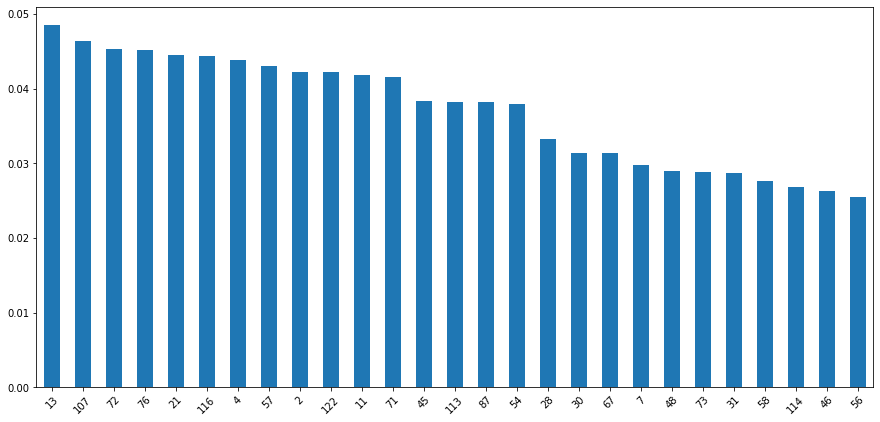

In [140]:
feat_importances = pd.Series(importances, index=selected_features)
feat_importances.nlargest(30).plot(kind='bar', rot=45, figsize=(15,7));

In [141]:
predictions = randsearch_rf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       476
           1       0.65      0.66      0.65       476
           2       0.65      0.71      0.68       461

    accuracy                           0.66      1413
   macro avg       0.66      0.66      0.66      1413
weighted avg       0.66      0.66      0.66      1413



In [142]:
X_final_test[selected_features]

,28,54,2,45,57,76,116,107,71,11,...,87,4,30,31,56,73,46,58,7,114
0,-1.651179,2.625624,0.424460,-1.429084,-3.011217,0.481778,-1.064541,0.040796,-1.435994,4.720857,...,0.786281,7.693946,40.676430,0.535096,1.018317,4.856697,0.419302,0.714613,0.025091,10.890676
1,2.220950,0.682162,3.509217,-0.341400,4.235636,2.927998,-4.318181,1.413569,-0.654818,9.894630,...,88.062350,6.893150,5.861128,0.043129,1.112535,-16.992830,0.984911,0.740651,1.012632,-6.192967
2,-3.148091,-3.765401,0.003076,-2.910801,-6.264697,3.188125,-4.435824,24.719778,-5.955837,1.335711,...,585.902732,11.334080,0.502407,0.319250,0.733980,-3.677816,0.216159,0.240055,18.930592,12.382752
3,-0.896586,-1.885291,0.017666,-3.925404,1.736836,-2.524108,6.202410,5.060159,3.418909,228.594140,...,77.535330,2.660978,0.776929,-0.631580,0.442199,-2.766680,0.526922,2.233170,0.140636,9.471649
4,5.257986,0.383375,0.004350,-1.804224,4.053626,-3.186689,-0.346151,0.046974,-2.500249,255.045817,...,225.671639,0.542074,1.010544,-2.151093,0.828549,-3.099961,0.069791,1.201226,2.823077,14.110742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.293177,-4.176583,0.010656,0.292386,-1.032756,-2.353286,-3.576705,2.326178,-7.953103,12.111438,...,0.693149,0.113467,2.498103,2.074596,0.166348,-10.636979,0.507650,0.957530,3.522302,-23.222719
19996,4.301669,-1.065257,0.002032,3.880091,2.452386,1.421497,-2.985609,0.209069,1.355000,1484.131591,...,1484.131591,1.307210,1.135913,-0.456076,3.024247,8.506704,0.976415,0.087600,7.470686,3.828716
19997,-2.761837,0.200529,0.122727,-5.757901,3.392497,-2.241271,-3.294669,1.811649,-3.320449,36.596743,...,12.661762,0.947975,0.109342,-0.290029,0.850049,-7.448871,0.856316,0.650097,24.345709,3.334561
19998,-1.286394,3.916386,0.024491,-0.047631,2.941546,-0.023766,0.300117,5.069696,-0.287965,3.157753,...,0.026858,0.098936,4.824145,-1.338143,0.315307,-18.470808,0.078406,1.258143,33.376886,2.881706


In [143]:
predictions = randsearch_rf.best_estimator_.predict(X_final_test[X_test.columns])
pred_copy = predictions

In [144]:
type(predictions)

numpy.ndarray

In [145]:
df = pd.DataFrame(predictions, columns = ["Predicted"])
df

,Predicted
0,2
1,2
2,1
3,1
4,1
...,...
19995,1
19996,2
19997,1
19998,1


In [147]:
df.to_csv("df4.csv")

### Light GMB

In [153]:
pipe_rf = Pipeline([("scl", StandardScaler()), ('select_K_features', SelectKBest(f_classif)), ('clf', lgb())])

parameters_rf = {'select_K_features__k': range(27, 30), 
                 'clf__objective' : multiclass,
                 'clf__n_estimators' : np.linspace(50, 1200).astype(int), 
                 'clf__learning_rate' : np.around(np.linspace(0.01, 0.08, 15), decimals=3),
                 'clf__max_depth' : range(2, 10),
                 'clf__min_child_weight' : [0, 1],
                }

randsearch_rf = RandomizedSearchCV(pipe_rf, parameters_rf, cv = 5, scoring = 'f1_macro', n_jobs=-1, n_iter=10, verbose = 1)

randsearch_rf.fit(X_train,y_train)

NameError: name 'lgb' is not defined

### Evaluation Process:

Sklearn scoring technique to increase is ‘f1_macro’. To submit the results on Kaggle, save the predictions to CSV file with the column names ‘Id’ and ‘Predicted’. No index column!

Submit your CSV file in ‘Submit Predictions’ section.